# Semantic Segmentation of Hyperspectral Images

Semantic segmentation is an image processing technique that involves assigning each pixel in the image to a semantic class. In this context, a semantic class represents an object or region in the image that has a specific meaning. Semantic segmentation is a challenging task, as it requires a deep understanding of the image's content. In this notebook, we will explore semantic segmentation of hyperspectral images using a *convolutional neural network* (CNN).

<img src="./images/1.jpeg" width="50%">


To perform semantic segmentation of hyperspectral images using convolutional neural networks, we will use the `Keras` library to define the architecture and train the network.


In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling3D, Conv3DTranspose, Flatten, Dense, Conv3D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU


### Instantiating the Data from Hyperspectral Image Datasets:

1. **Salinas**: The Salinas dataset is a hyperspectral dataset containing aerial images of an agricultural field in Salinas Valley, California. The dataset has 224 spectral bands and 512 pixels x 217 lines.
2. **Indian Pines**: The Indian Pines dataset is a hyperspectral dataset containing aerial images of an agricultural field in Indiana. The dataset has 220 spectral bands and 145 pixels x 145 lines.
3. **Pavia Center**: The Pavia Center dataset is a hyperspectral dataset containing aerial images of a city in Italy. The dataset has 102 spectral bands and 1096 pixels x 715 lines.

The datasets were obtained from [here](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes).


In [2]:
# Load hyperspectral image data
#DIR_NAME = 'indian_pines'
#DIR_NAME = 'pavia'
DIR_NAME = 'salinas'

x_name = './datasets/' + DIR_NAME + '/' + DIR_NAME + '.mat'
y_name = './datasets/' + DIR_NAME + '/' + DIR_NAME + '_gt.mat'

X_3d = loadmat(x_name)[DIR_NAME]
y_3d = loadmat(y_name)[DIR_NAME + '_gt']
n, m = y_3d.shape
n_clases = len(np.unique(y_3d))
print(f"Number of classes: {n_clases}")

print(f"X shape: {X_3d.shape}, {X_3d.dtype}")
print(f"y shape: {y_3d.shape}, {y_3d.dtype}")

Number of classes: 17
X shape: (512, 217, 224), int16
y shape: (512, 217), uint8


We plot a spectral band of the image and the labels associated with each pixel to visualize the data.


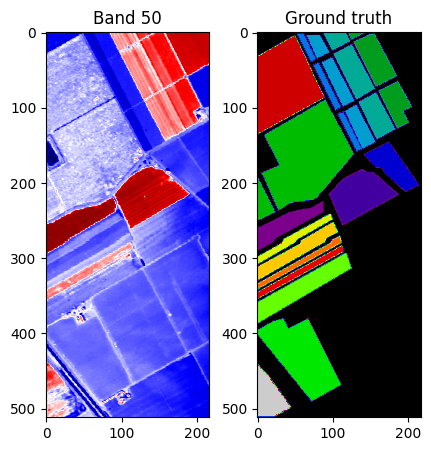

In [3]:
# plot a band from X and the ground truth y
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(X_3d[:, :, 50], cmap='seismic')
ax[0].set_title('Band 50')
ax[1].imshow(y_3d, cmap='nipy_spectral')
ax[1].set_title('Ground truth')
plt.show()

To train the network quickly and easily, we will reduce the dimensionality of the images using `PCA`. The image dimensions will be reduced to 10 principal components, which retain over 95% of the data variance, for each dataset.


Explained variance with PCA: 0.9996116011368107
X_pca shape: (512, 217, 10), float64


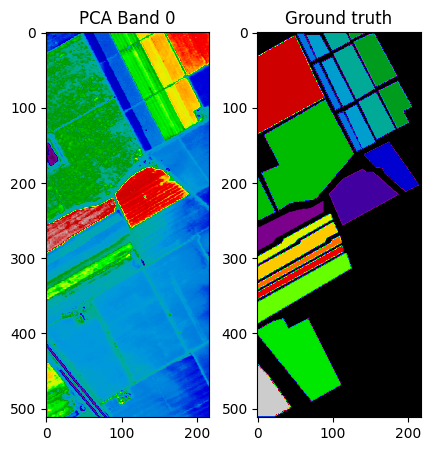

In [4]:
def reduce_data(X, n_components=10):
    X_flat = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_flat)
    
    print(f"Explained variance with PCA: {pca.explained_variance_ratio_.sum()}")
    
    #plot explained variance
    #plt.plot(np.cumsum(pca.explained_variance_ratio_))
    
    X_pca = np.reshape(X_pca, (X.shape[0], X.shape[1], n_components))
    
    return X_pca, pca

X_pca, pca = reduce_data(X_3d, n_components=10)
print(f"X_pca shape: {X_pca.shape}, {X_pca.dtype}")

# plot a band from X and the ground truth y
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(X_pca[:, :, 0], cmap='nipy_spectral')
ax[0].set_title('PCA Band 0')
ax[1].imshow(y_3d, cmap='nipy_spectral')
ax[1].set_title('Ground truth')
plt.show()

We resize the images to 144x144 pixels so that we can use a single network for all datasets, regardless of the image dimensions. This way, there is no need to define a separate network for each dataset or adjust it for different image sizes.


X_sq shape: (144, 144, 10), float64
y_sq shape: (144, 144), uint8


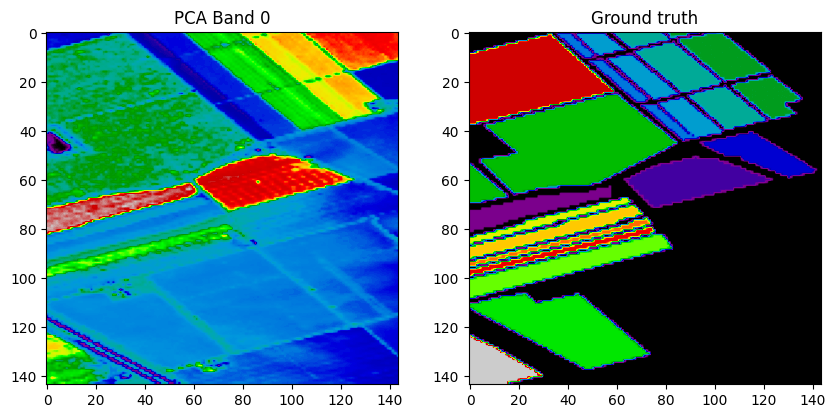

In [5]:
dim = 144

X_sq = cv2.resize(X_pca, (dim, dim))
y_sq = cv2.resize(y_3d, (dim, dim))

print(f"X_sq shape: {X_sq.shape}, {X_sq.dtype}")
print(f"y_sq shape: {y_sq.shape}, {y_sq.dtype}")

#plot a band from X and the ground truth y
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X_sq[:, :, 0], cmap='nipy_spectral')
ax[0].set_title('PCA Band 0')
ax[1].imshow(y_sq, cmap='nipy_spectral')
ax[1].set_title('Ground truth')
plt.show()


To classify and later segment the images, we create a label matrix for each pixel in the image using **One-Hot Encoding**. This transforms the labels into a cube of binary images, where each channel represents a class. If the pixel belongs to the respective class, the pixel value is 1, otherwise, it is 0.

<img src=./images/ohe.png width=50%>

one_hot shape: (144, 144, 17), float64
y shape: (1, 144, 144, 17), float64
X shape: (1, 144, 144, 10, 1), float64


Text(0.5, 1.0, 'One hot encoding of class 15')

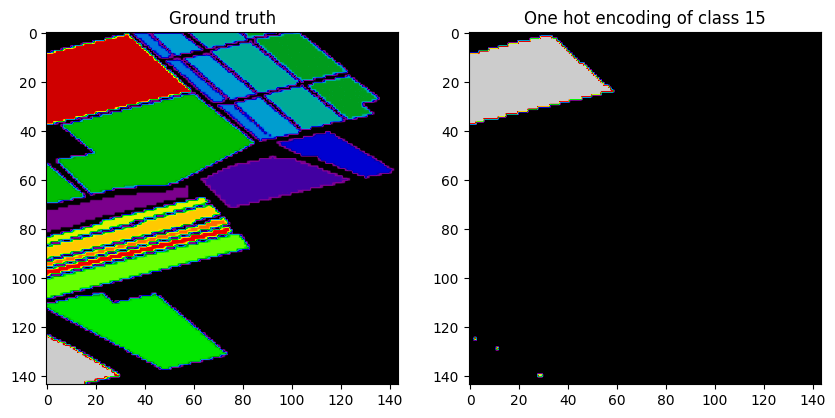

In [6]:
one_hot = np.zeros((dim, dim, n_clases))
for i, unique_value in enumerate(np.unique(y_sq)):
    one_hot[:, :, i][y_sq == unique_value] = 1
    
print(f"one_hot shape: {one_hot.shape}, {one_hot.dtype}")

y = one_hot.reshape(1, dim, dim,  n_clases)
print(f"y shape: {y.shape}, {y.dtype}")

X = X_sq.reshape(-1, dim, dim, X_sq.shape[2], 1)
print(f"X shape: {X.shape}, {X.dtype}")

# plot ground truth and one hot encoding
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(y_sq, cmap='nipy_spectral')
ax[0].set_title('Ground truth')
ax[1].imshow(one_hot[:, :, 15], cmap='nipy_spectral')
ax[1].set_title('One hot encoding of class 15')

### Defining the Convolutional Neural Network:

The neural network used is based on the **`U-Net`** architecture, which is a deep convolutional network designed for semantic image segmentation. U-Net is an encoder-decoder network that uses skip connections to transfer information from the encoder to the decoder. This enables the network to combine information from different resolution levels to improve segmentation performance.

<img src="./images/Architecture.jpg" width="70%">

The U-Net network consists of the following components:
1. **Encoder**: The encoder is made up of a series of convolutional layers that reduce the image size and extract meaningful features.
2. **Decoder**: This part takes the encoder's output and enlarges it to the original image size using **transposed convolutional layers**.
3. **Skip Connections**: These connections transfer information directly from the encoder to the decoder without modification. This allows the network to combine information from different resolution levels, enhancing the segmentation performance.
4. **Output Layer**: The output layer is a convolutional layer with a softmax activation function that assigns each pixel to a class.

In [7]:
def get_model(n_bands, n_clases):
    inputs = Input((144, 144, n_bands, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    upconv1 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same', activation='relu')(conv4), conv3], axis=3)
    
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(upconv1)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    upconv2 = concatenate([Conv3DTranspose(64, (2, 2,2 ), strides=(2, 2, 2), padding='same', activation='relu')(conv5), conv2], axis=3)
    
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(upconv2)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    upconv3 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same', activation='relu')(conv6), conv1], axis=3)
    
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(upconv3)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)

    conv3d_shape = conv7.shape

    conv8 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv7)

    output = Conv2D(n_clases, (1, 1), activation='softmax', name='output')(conv8)

    model = Model(inputs=[inputs], outputs=[output])

    model.compile(optimizer=Adam(learning_rate=0.001), loss={'output': 'categorical_crossentropy'},
                  metrics={'output': MeanIoU(num_classes=n_clases)})

    return model

To evaluate the performance of the network, we will use **IoU (Intersection over Union)** as the evaluation metric. IoU measures the overlap between the network's predictions and the true labels of the image. The higher the IoU, the more accurate the segmentation.

$$ IoU = \frac{A \cap B}{A \cup B}= \frac{TP}{TP + FP + FN} $$

In [8]:
model = get_model(n_bands=X.shape[3], n_clases=n_clases)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 144, 144,  │          0 │ -                 │
│ (InputLayer)        │ 10, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 144, 144,  │        896 │ input_layer[0][0] │
│                     │ 10, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 144, 144,  │     27,680 │ conv3d[0][0]      │
│                     │ 10, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 72, 72, 5, │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 72, 72, 5, │     55,360 │ max_pooling3d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 72, 72, 5, │    110,656 │ conv3d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 36, 36, 2, │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 36, 36, 2, │    221,312 │ max_pooling3d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 36, 36, 2, │    442,496 │ conv3d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 18, 18, 1, │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 18, 18, 1, │    884,992 │ max_pooling3d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 18, 18, 1, │  1,769,728 │ conv3d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 36, 36, 2, │    262,272 │ conv3d_7[0][0]    │
│ (Conv3DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 36, 4, │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 36, 36, 4, │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 36, 36, 4, │    442,496 │ conv3d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 72, 72, 8, │     65,600 │ conv3d_9[0][0]  

 Total params: 5,038,673 (19.22 MB)

 Trainable params: 5,038,673 (19.22 MB)

 Non-trainable params: 0 (0.00 B)

We train the network and save it for later use in hyperspectral image segmentation.


In [9]:
with tf.device('/GPU:0'):
    history = model.fit(x=X, y=y, batch_size=1, epochs=250, verbose=1)
    print("Model trained")

    y_pred = model.predict(X)
    print(f"y_pred shape: {y_pred.shape}, {y_pred.dtype}")

# save the model
#    model.save("./models/" + DIR_NAME + '_model.keras')

Epoch 1/250


c:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 144, 144, 10, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 63.4095 - mean_io_u: 0.4682
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 69.6644 - mean_io_u: 0.6750
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 54.7389 - mean_io_u: 0.6287
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 39.0363 - mean_io_u: 0.5811
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 22.7538 - mean_io_u: 0.5987
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 15.2869 - mean_io_u: 0.5600
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 11.1134 - mean_io_u: 0.5459
Epoch 8/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 8.0914 - mean_io_u: 0.5084
Epoch 9/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.9003 - mean_io_u: 0.4885
Epoch 10/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.7656 - mean_io_u: 0.4820
Epoch 11/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.9389 - mean_io_u: 0.4795
Epoch 12/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.2980 - mean_io_u: 0.4787
Epoc

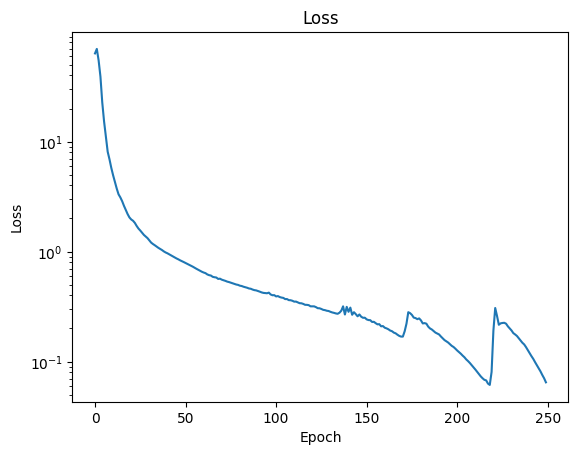

In [10]:
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()


With the obtained results, we create a segmentation mask to visualize the semantic segmentation of hyperspectral images.


Prediction mask shape:  (144, 144)


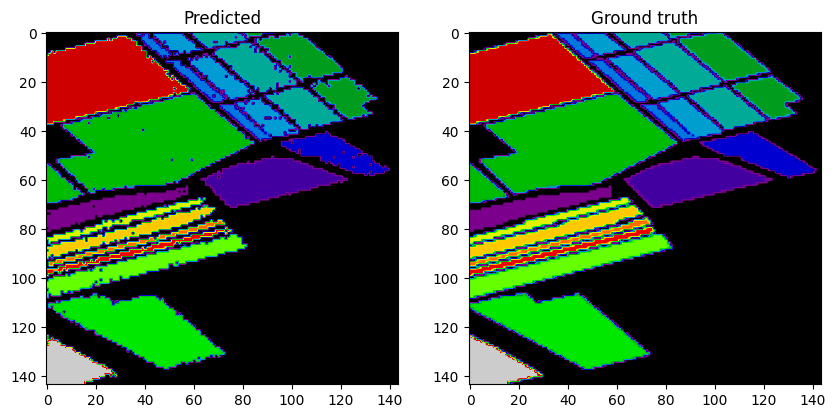

In [11]:
def create_prediction_mask(y_pred):
  mask_pred = np.zeros((dim, dim))
  for i in range(dim):
    for j in range(dim):
      index = np.argmax(y_pred[0][i][j])
      if y_pred[0][i][j][index]<0.85:
        mask_pred[i][j] = 0
      else:
        mask_pred[i][j] = np.argmax(y_pred[0][i][j])
        
  print("Prediction mask shape: ", mask_pred.shape)
  return mask_pred

y_gt = cv2.resize(y_3d, (dim, dim))
mask_pred = create_prediction_mask(y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_pred, cmap='nipy_spectral')
ax[0].set_title('Predicted')
ax[1].imshow(y_gt, cmap='nipy_spectral')
ax[1].set_title('Ground truth')
plt.show()

Finally, we calculate the IoU score to evaluate the performance of the network on the datasets used.


In [12]:
intersection = np.logical_and(y_gt, mask_pred)
union = np.logical_or(y_gt, mask_pred)

iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU score: {iou_score}")

IoU score: 0.9061019518665908


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Accuracy: 0.9855324074074074
precision mean: 0.9718620752079972
recall mean: 0.9719469217920343
F1 mean: 0.9717338981525904


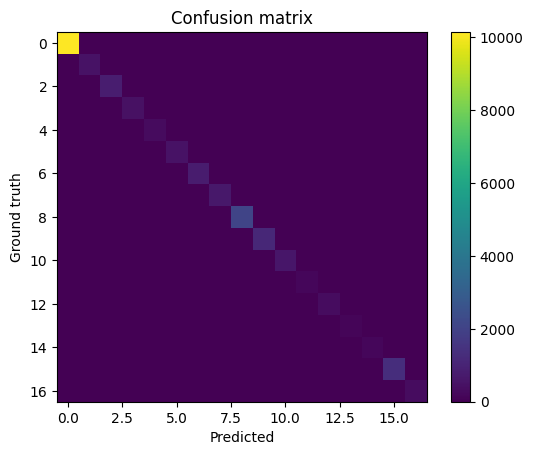

In [13]:
y_pred = model.predict(X)
y_pred = np.squeeze(y_pred)
y_pred = np.argmax(y_pred, axis=-1)

# confusion matrix
confusion_matrix = np.zeros((n_clases, n_clases))
for i in range(n_clases):
    for j in range(n_clases):
        confusion_matrix[i, j] = np.sum((y_gt == i) & (y_pred == j))
        
# print("Confusion matrix:")
# print(confusion_matrix)

# plot the confusion matrix
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Ground truth')
plt.title('Confusion matrix')

# compute the accuracy
accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
print(f"Accuracy: {accuracy}")

# compute the precision
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
#print(f"precision: {precision}")
print(f"precision mean: {np.mean(precision)}")

# compute the recall
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
#print(f"recall: {recall}")
print(f"recall mean: {np.mean(recall)}")

# compute the F1 score
f1 = 2 * precision * recall / (precision + recall)
#print(f"F1: {f1}")
print(f"F1 mean: {np.mean(f1)}")
